## Credit Card Fraud Model Development

@ Sharvari Dhote - Slef-learning DS - Capstone project 1
* Implemented pipeline and compared multiple classification models such as logistic regression, random forest, decision. trees, adaptive boosting and gradient boosting techniques for the fraud imbalance dataset. 

* Dataset - credi card dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* Input - 31 features with 28 PCA transformed features except 'Time' and 'Amount'

* Output - Feature 'Class'  and it takes value 1 in case of fraud and 0 otherwise. 


** Data credit : Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015Credit Card Fraud Detection : Anonymized credit card transactions labeled as fraudulent or genuine

In [1]:
#%%
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Importing the dataset
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# path = "C:/Users/rakes/Google Drive (dhote.sharvari@gmail.com)/Data_Science_portfolio/Project_2/creditcardfraud/"
dataset = pd.read_csv('creditcard.csv')

# Last column is a binary class; rest all columns are features
X_orig = dataset.iloc[:,0:-1]
y_orig = dataset.iloc[:, -1]

print("Dataset size : ", dataset.shape)

Dataset size :  (284807, 31)


In [3]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X = sc.fit_transform(X_orig)
y = y_orig

print('X : ', X.shape, '\n')
print('y : Number of class values \n', y.value_counts(), '\n')
print('y : Number of class values % \n', y.value_counts(normalize=True))

X :  (284807, 30) 

y : Number of class values 
 0    284315
1       492
Name: Class, dtype: int64 

y : Number of class values % 
 0    0.998273
1    0.001727
Name: Class, dtype: float64


In [4]:
# Resampling using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, y)

print('X_smote : ', X_smote.shape, '\n')
print('y_smote : ', y_smote.shape)

X_smote :  (568630, 30) 

y_smote :  (568630,)


In [5]:
from sklearn.model_selection import train_test_split

# data split on original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [6]:
# Correlation 
cor = dataset.corr()

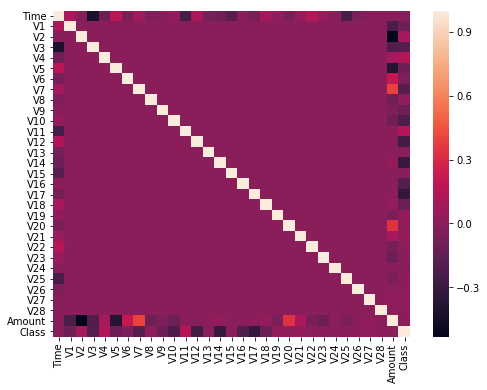

In [7]:
import seaborn as sns
size = 6
plt.figure(figsize=(size+2, size))
sns.heatmap(cor)

In [8]:
# Importing all the packages and libraries
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

In [40]:
# grid search function that returns best classifier, true positive rate, false positive rate and auc scores

import time
import seaborn as sns
%matplotlib inline

def gridsearch(pipeline, param_grid, X_train, y_train, X_test, y_test, foldsk=3, scoring_index='roc_auc'):
    #y_test_legit = y_test.value_counts()[0]
    #y_test_fraud = y_test.value_counts()[1]
    y_test_legit= np.count_nonzero(y_test==0)
    y_test_fraud = np.count_nonzero(y_test==1)
    start = time.time()
    gs = GridSearchCV(pipeline,
              		param_grid = param_grid,
              		scoring = scoring_index,
              		cv=foldsk, # stratified
              		refit=scoring_index,
              		return_train_score=False)
    
    gs.fit(X_train, y_train)
    probas_ = gs.predict_proba(X_test)
    
    tprs = []
    aucs = []
    mfpr = np.linspace(0, 1, 100)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    
    tprs.append(np.interp(mfpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    mtpr = np.mean(tprs, axis=0)
    mtpr[-1] = 1.0
    mauc = auc(mfpr, mtpr)
    
    endt = time.time()
    print('Time elapsed = ', (endt - start)/60, ' mins \n')
    print('Best Estimator : ', gs.best_estimator_,' \n')
    print('Best Score AUC : ', gs.best_score_,' \n')
    
    pred = gs.predict(X_test)
    print('---Classification Report---\n')
    print(classification_report(y_test,pred),' \n')
    
    # confusion matrix
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit, 1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    return gs.best_estimator_, mtpr, mfpr, mauc

In [41]:
# plot roc curve

def plot_roc_curves(classifiers, clf_names, tprs, fprs, aucs, xlim=(-0.05, 1.05), ylim=(-0.05, 1.05)):
    colors = ['b', 'g', 'c', 'k', 'm', 'y']
    
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    for i in range(len(aucs)):
        f = fprs[i]
        t = tprs[i]
        plt.plot(f, t, 
             color=colors[i],
             label=r'ROC {} (AUC = {:.4f})'.format(clf_names[i], aucs[i]),
             lw=2, 
             alpha=.8)

    plt.xlim([xlim[0], xlim[1]])
    plt.ylim([ylim[0], ylim[1]])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

## Raw Data

In [11]:
# Define empty lists to save results

classifiers = []
tprs =[]
fprs = []
aucs = []
clf_names = []

Time elapsed =  3.339758618672689  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.1, verbose=0, warm_start=False))])  

Best Score AUC :  0.9808565477490528  

---Classification Report---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.85      0.63      0.72       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.92      0.81      0.86     71202
weighted avg       1.00      1.00      1.00     71202
  



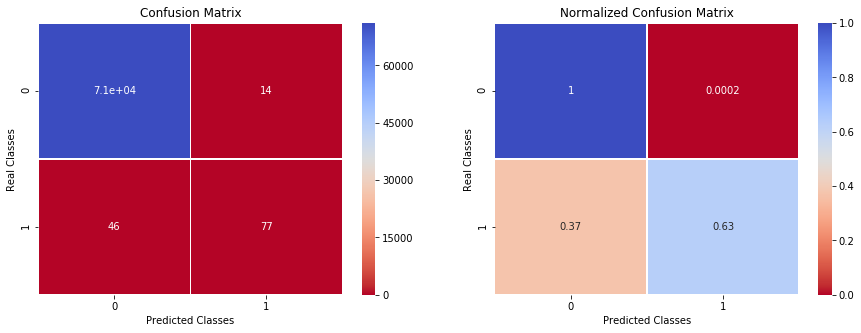

In [12]:
# Logistic Regression

clfname = 'Logistic Regression'

pipeline_LR = Pipeline([
					 ('clf', LogisticRegression())
					 ])

param_grid_LR = [{ 
			   'clf__C': [0.5, 1, 10, 10**2],
			   'clf__class_weight': [None, 'balanced'],  
			   'clf__tol': [10**-1, 10**-3, 10**-5]
	}]
    
clf, tpr, fpr, auroc = gridsearch(pipeline_LR, 
                                  param_grid_LR, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names.append(clfname)
classifiers.append(clf)
tprs.append(tpr)
fprs.append(fpr)
aucs.append(auroc)

Time elapsed =  326.01768388748167  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])  

Best Score AUC :  0.9838163966951595  

---Classification Report---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.77      0.86       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202
  



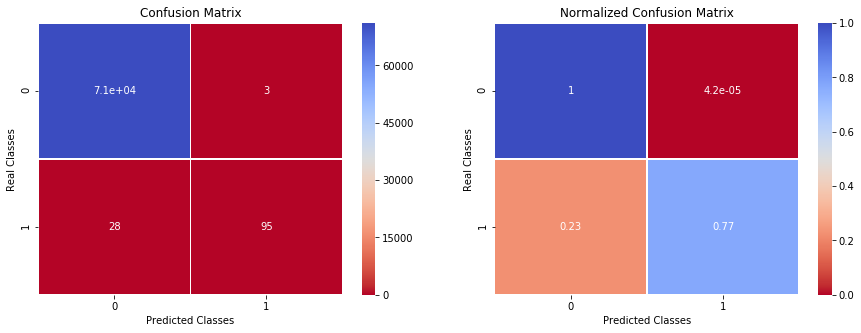

In [13]:
# RandomForestClassifier

clfname = 'Random Forest'

pipeline_RF = Pipeline([ 
					 ('clf', RandomForestClassifier())
					 ])

param_grid_RF = [{ 
				 'clf__max_depth': [3, 5, 8],
				  'clf__min_samples_split': [5, 6, 8],
				'clf__criterion': ['gini', 'entropy'],
                'clf__n_estimators': [50, 100, 500]
	}]  

clf, tpr, fpr, auroc = gridsearch(pipeline_RF, 
                                  param_grid_RF, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names.append(clfname)
classifiers.append(clf)
tprs.append(tpr)
fprs.append(fpr)
aucs.append(auroc)

Time elapsed =  3.2740173657735188  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])  

Best Score AUC :  0.8900402844187979  

---Classification Report---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.80      0.70      0.75       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.90      0.85      0.87     71202
weighted avg       1.00      1.00      1.00     71202
  



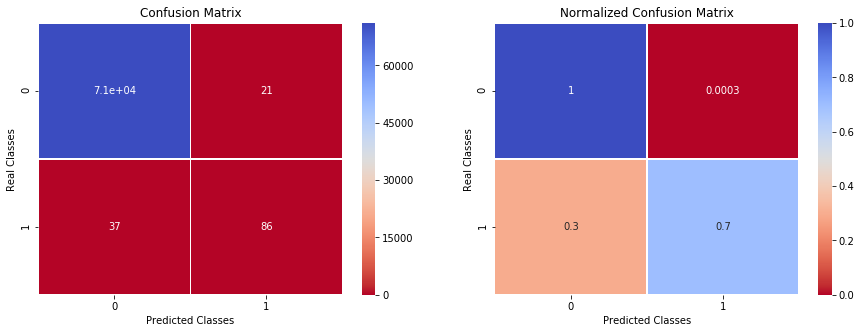

In [14]:
# Decision Tree

clfname = 'Decision Tree'

pipeline_DT = Pipeline([ 
					 ('clf', DecisionTreeClassifier())
					 ])

param_grid_DT = [{ 
			   'clf__criterion': ['gini', 'entropy'],
			   'clf__min_samples_split': [4, 6, 10]#,
# 			   'clf__max_depth': [2,4,6]
			   }]

clf, tpr, fpr, auroc = gridsearch(pipeline_DT, 
                                  param_grid_DT, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names.append(clfname)
classifiers.append(clf)
tprs.append(tpr)
fprs.append(fpr)
aucs.append(auroc)

Time elapsed =  28.57938326994578  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=60, random_state=None))])  

Best Score AUC :  0.9816764149558949  

---Classification Report---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.83      0.57      0.68       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.92      0.78      0.84     71202
weighted avg       1.00      1.00      1.00     71202
  



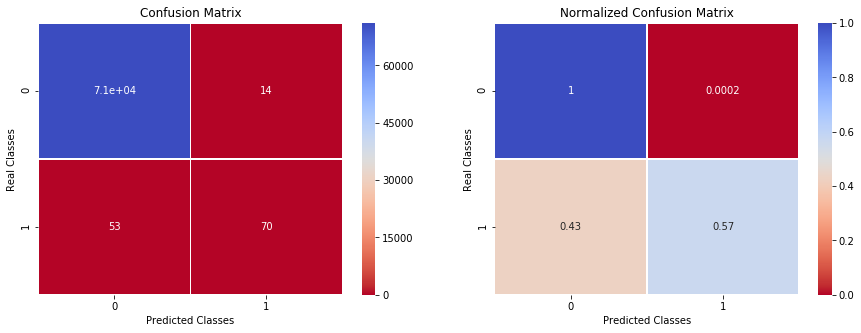

In [15]:
# Adaptive boosting

clfname = 'Adaptive boosting'

pipeline_AdaB = Pipeline([  
					 ('clf', AdaBoostClassifier())
					 ])

param_grid_AdaB = [{ 
			   'clf__n_estimators': [10, 40, 60, 100],
				 'clf__learning_rate': [0.1, 0.5, 1, 5]
			  # 'clf__base_estimator':[DecisionTreeClassifier()]
			   }]

clf, tpr, fpr, auroc = gridsearch(pipeline_AdaB, 
                                  param_grid_AdaB, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names.append(clfname)
classifiers.append(clf)
tprs.append(tpr)
fprs.append(fpr)
aucs.append(auroc)

Time elapsed =  5.016283631324768  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])  

Best Score AUC :  0.7724880987117798  

---Classification Report---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.69      0.18      0.28       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.84      0.59      0.64     71202
weighted avg       1.00      1.00      1.00     71202
  



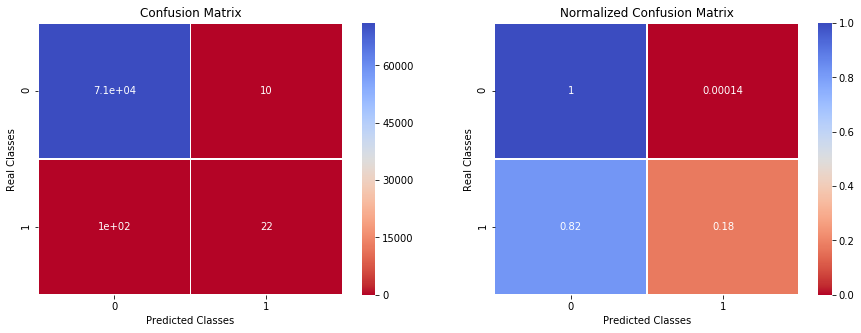

In [16]:
# Gradient Boost

clfname = 'Gradient Boost'

pipeline_GB = Pipeline([ 
					 ('clf', GradientBoostingClassifier())
					 ])

param_grid_GB = [{ 
# 			   'clf__max_depth': [2, 3, 5],
# 				'clf__n_estimators': [5, 10, 20, 50]
				}]

clf, tpr, fpr, auroc = gridsearch(pipeline_GB, 
                                  param_grid_GB, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names.append(clfname)
classifiers.append(clf)
tprs.append(tpr)
fprs.append(fpr)
aucs.append(auroc)

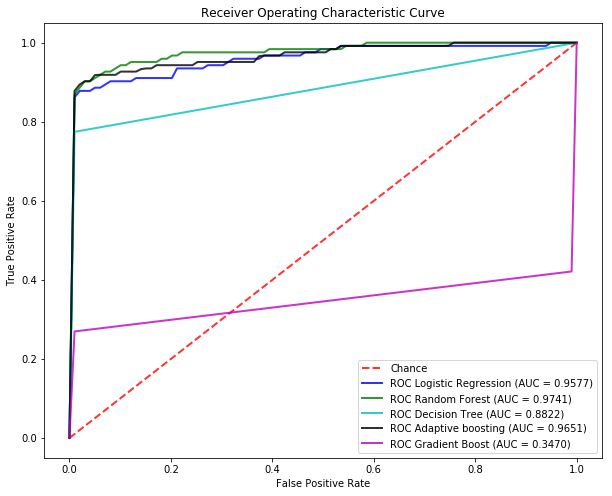

In [17]:
plot_roc_curves(classifiers, clf_names, tprs, fprs, aucs, xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))

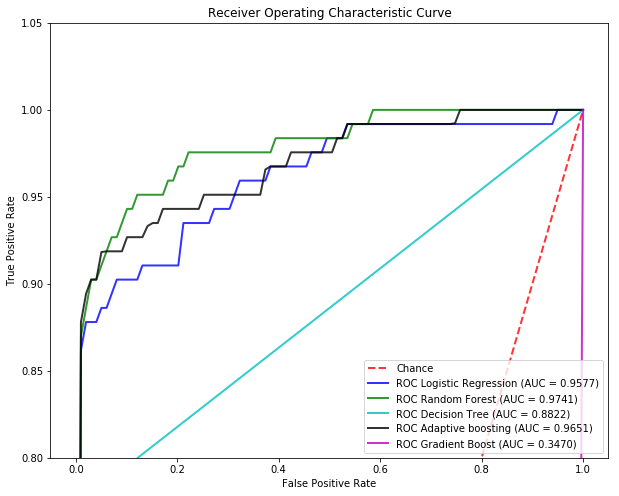

In [18]:
plot_roc_curves(classifiers, clf_names, tprs, fprs, aucs, xlim=(-0.05, 1.05), ylim=(0.8, 1.05))

## Balancing data using SMOTE 

In [42]:
# data split on SMOTE dataset
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42, stratify=y_smote)

In [43]:
# Define empty lists to save results

classifiers_s = []
tprs_s =[]
fprs_s = []
aucs_s = []
clf_names_s = []

Time elapsed =  5.079773696263631  mins 

Best Estimator :  Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=1e-05, verbose=0, warm_start=False))])  

Best Score AUC :  0.9896694523758802  

---Classification Report---

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     71079
           1       0.97      0.92      0.95     71079

   micro avg       0.95      0.95      0.95    142158
   macro avg       0.95      0.95      0.95    142158
weighted avg       0.95      0.95      0.95    142158
  



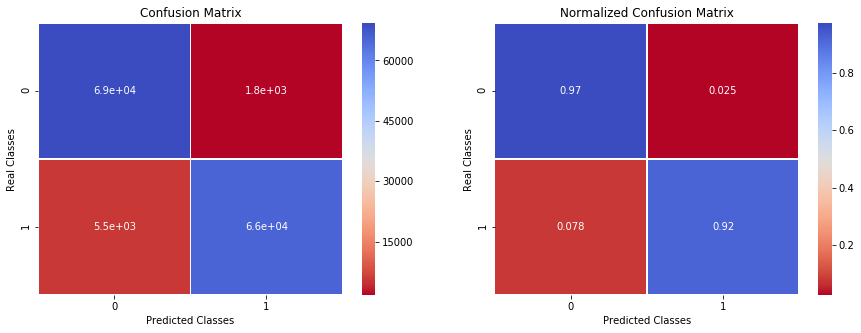

In [44]:
# Logistic Regression

clfname = 'Logistic Regression'

pipeline_LR = Pipeline([
					 ('clf', LogisticRegression())
					 ])

param_grid_LR = [{ 
			   'clf__C': [0.5, 1, 10, 10**2],
			   'clf__class_weight': [None, 'balanced'],  
			   'clf__tol': [10**-1, 10**-3, 10**-5]
	}]
    
clf, tpr, fpr, auroc = gridsearch(pipeline_LR, 
                                  param_grid_LR, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names_s.append(clfname)
classifiers_s.append(clf)
tprs_s.append(tpr)
fprs_s.append(fpr)
aucs_s.append(auroc)

In [45]:
# RandomForestClassifier

clfname = 'Random Forest'

pipeline_RF = Pipeline([ 
					 ('clf', RandomForestClassifier())
					 ])

param_grid_RF = [{ 
				 'clf__max_depth': [3, 5, 8],
				  'clf__min_samples_split': [5, 6, 8],
				'clf__criterion': ['gini', 'entropy'],
                'clf__n_estimators': [50, 100, 500]
	}]  

clf, tpr, fpr, auroc = gridsearch(pipeline_RF, 
                                  param_grid_RF, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names_s.append(clfname)
classifiers_s.append(clf)
tprs_s.append(tpr)
fprs_s_s.append(fpr)
aucs_s.append(auroc)

KeyboardInterrupt: 

In [ ]:
# Decision Tree

clfname = 'Decision Tree'

pipeline_DT = Pipeline([ 
					 ('clf', DecisionTreeClassifier())
					 ])

param_grid_DT = [{ 
			   'clf__criterion': ['gini', 'entropy'],
			   'clf__min_samples_split': [2, 4, 5, 6, 10],
			   'clf__max_depth': [2,4,6]
			   }]

clf, tpr, fpr, auroc = gridsearch(pipeline_DT, 
                                  param_grid_DT, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names_s.append(clfname)
classifiers_s.append(clf)
tprs_s.append(tpr)
fprs_s.append(fpr)
aucs_s.append(auroc)

In [ ]:
# Adaptive boosting

clfname = 'Adaptive boosting'

pipeline_AdaB = Pipeline([  
					 ('clf', AdaBoostClassifier())
					 ])

param_grid_AdaB = [{ 
			   'clf__n_estimators': [10, 40, 60, 100],
				 'clf__learning_rate': [0.1, 0.5, 1, 5]
			  # 'clf__base_estimator':[DecisionTreeClassifier()]
			   }]

clf, tpr, fpr, auroc = gridsearch(pipeline_AdaB, 
                                  param_grid_AdaB, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names_s.append(clfname)
classifiers_s.append(clf)
tprs_s.append(tpr)
fprs_s.append(fpr)
aucs_s.append(auroc)

In [ ]:
# Gradient Boost

clfname = 'Gradient Boost'

pipeline_GB = Pipeline([ 
					 ('clf', GradientBoostingClassifier())
					 ])

param_grid_GB = [{ 
# 			   'clf__max_depth': [2, 3, 5],
# 				'clf__n_estimators': [5, 10, 20, 50]
				}]

clf, tpr, fpr, auroc = gridsearch(pipeline_GB, 
                                  param_grid_GB, 
                                  X_train, y_train, 
                                  X_test, y_test, 
                                  foldsk=3, 
                                  scoring_index='roc_auc')

clf_names_s.append(clfname)
classifiers_s.append(clf)
tprs_s.append(tpr)
fprs_s.append(fpr)
aucs_s.append(auroc)

In [ ]:
plot_roc_curves(classifiers_s, clf_names_s, tprs_s, fprs_s, aucs_s, xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))

In [ ]:
plot_roc_curves(classifiers_s, clf_names_s, tprs_s, fprs_s, aucs_s, xlim=(-0.05, 1.05), ylim=(0.8, 1.05))